## Package Description

`bmdrc` is a python library for calculating **B**ench**m**ark **D**ose **R**esponse **C**urves. This tutorial will take users through the library using a dichotomous (binary response) example. `bmdrc` is broken up into five modules 

1. *Input Data Module:* Import data into the python library.

2. *Pre-Processing Module:* Combine and remove endpoints as needed.

3. *Filtering Modules:* Apply recommended filters from the EPA and statistics experts.

4. *Model Fitting Modules:* Fit recommended models from the EPA and experts. The best fit model is autoselected for you.

5. *Output Modules:* Select tables to output as csvs. View plots in a HTML report.

First, install the package from pip using: 

`pip install bmdrc`

Or from github using: 

`pip install git+https://github.com/PNNL-CompBio/bmdrc`

## Datatype Description

**Dichotomous Data**

- *BinaryClass* The `BinaryClass` object contains specific pre-processing and filtering functions that pertain to plates and wells. Each value should be a 0, 1, or NA, and *bmdrc* will caculate the response column. The following columns are needed for data in long and wide format: chemical, plate, well, concentration. The following columns are only needed for data in wide format: endpoint, value. 

- *ProportionalClass* If your data does not contain plates and wells, the `ProportionalClass` object only requires a chemical, endpoint, concentration, and response (a proportion ranging from 0 to 1). Data must be in long format. 

- *LPRClass* In the `LPRClass`, larval photomotor response data can be converted to dichotomous as described in [Thomas et al 2019](https://www.sciencedirect.com/science/article/pii/S2468111318300732). Data must be in long format and contain the following columns: chemical, plate, well, concentration, time, and value. Users must specify the time between cycles, the cooldown time between cycles, and whether to start with a light or dark cycle. If this format does not fit your data nicely, please report it to the issues tab. 

**Continuous Data**

- *ContinuousClass* The `ContinuousClass` object requires only four columns: chemical, endpoint, concentration, and response (a continuous variable with any range). All selected models support negative numbers and zeroes. NA values are automatically filtered out. 

In [1]:
# Load locally installed libraries
import bmdrc
import pandas as pd

## Module 1: Input Data

The first step to using the bmdrc python library is to properly format the data. For light photomotor response data, use the `LPRClass` object which can be imported using `from bmdrc.LPRClass import LPRClass`. Next, read the data as a pandas dataframe. 

Note that the following columns must exist and be specified in the following format: chemical identifier (chemical.id), concentration (conc), plate ID (plate.id), well name (well), time (variable, listed as "t0" for the first measurement, "t1" for the second, etc), and value (movement in mm). The data must be provided in long format, as wide format is not an acceptable format option for LPR data. 

In [2]:
df = pd.read_csv("../data/LPR_Long.csv")
df.head()

,chemical.id,conc,plate.id,well,variable,value
0,2,0.0,20544,H01,t0,0.000
1,2,0.0,20544,H02,t0,NaN
2,2,0.0,20544,H03,t0,NaN
3,2,0.0,20544,H04,t0,1.083
4,2,0.0,20544,H05,t0,1.608


The following information must be provided to calculate LPR cycles: the cycle_length, the cycle_cooldown, and the starting_cycle value. In this specific instance, cycles are measured in 6 second intervals, so a length of 20 represents 120 second or 2 minutes. Between 2 minute measurement times, there are 1 minute cooldowns. Here, we calculate the difference in the area under the curve (AUC) between dark and light cycles, so specifying whether the first cycle - the starting cycle - is a "light" or "dark" cycle is important. The other endpoint that is calculated for this data, besides AUC, is MOV, which is the difference in movement between transtion periods. Here we have an example where the cycle_length is 120 seconds (20 sets of 6 second intervals), cycel_cooldown is 60 seconds (10 sets of 6 second intervals), and the first measurement is a "light" cycle.

![LPR_Image](./LPR_Example.png)

In [3]:
from bmdrc.LPRClass import LPRClass

# Convert the continuous data to dichotomous 
LPR = LPRClass(
    df = df,
    chemical = "chemical.id",
    plate = "plate.id",
    well = "well",
    concentration = "conc",
    time = "variable",
    value = "value",
    cycle_length = 20.0,
    cycle_cooldown = 10.0, 
    starting_cycle = "light"
)

...defining cycles
...calculating AUC values
...calculating MOV values


In [4]:
# Here we can see the dichotomous data, which follows the same format as we've seen for the morphological example in the "Binary Class Example" jupyter notebook
LPR.df[LPR.df["value"] > 0]

,chemical.id,conc,plate.id,well,endpoint,value
4,2,0.00,20544,H05,AUC1,1.0
9,2,0.00,20544,H10,AUC1,1.0
28,2,0.00,20625,H05,AUC1,1.0
33,2,0.00,20625,H10,AUC1,1.0
39,2,2.16,20544,G04,AUC1,1.0
...,...,...,...,...,...,...
2282,2,100.00,20624,A03,MOV4,1.0
2285,2,100.00,20624,A06,MOV4,1.0
2286,2,100.00,20624,A07,MOV4,1.0
2289,2,100.00,20624,A10,MOV4,1.0


## Module 2: Pre-Processing

For a full example of all functions is available in the "Binary Class Example" notebook. Here we will cover a few functions that are relevant for LPR data.

### LPR Class: Combine Endpoints

In [5]:
LPR.combine_and_create_new_endpoints({"ANY_MOV": ["MOV1", "MOV2", "MOV3", "MOV4"],
                                      "ANY_AUC": ["AUC1", "AUC2", "AUC3", "AUC4"]})

## Module 3: Filtering

For a full example of all functions is available in the "Binary Class Example" notebook. Here we will cover a few functions that are relevant for LPR data.

### Negative Control Filter

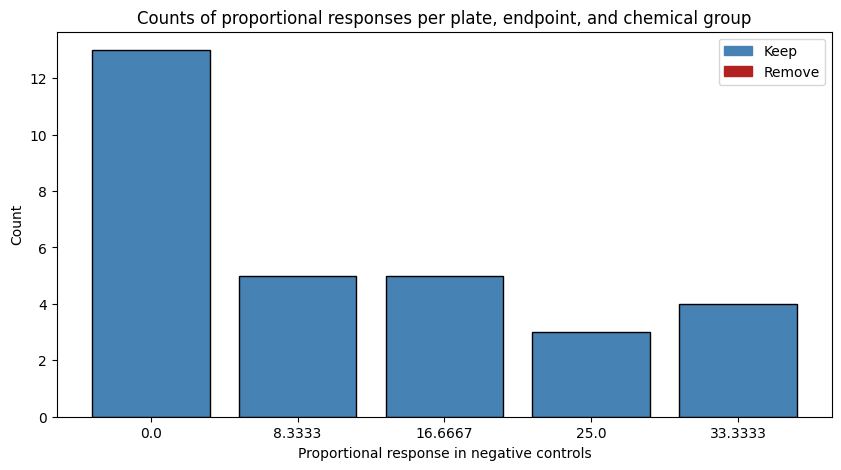

In [6]:
LPR.filter_negative_control(percentage = 50, apply = True, diagnostic_plot = True)

### Minimum Concentration Filter

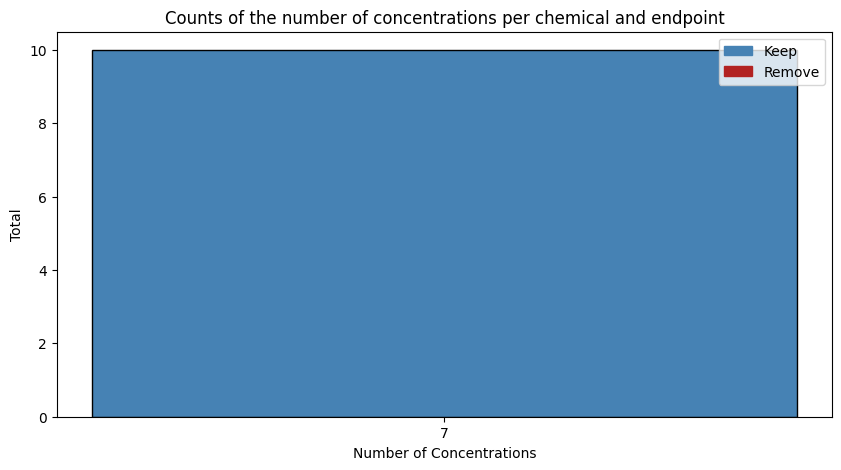

In [7]:
LPR.filter_min_concentration(count = 3, apply = True, diagnostic_plot = True)

### Correlation Score Filter

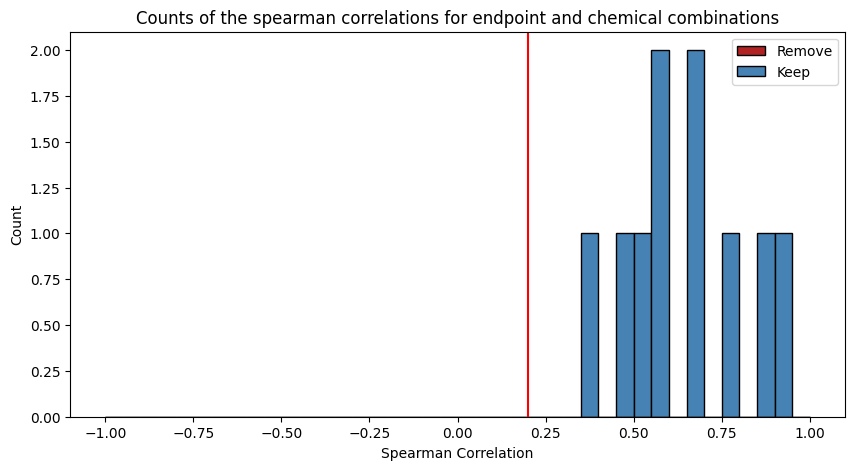

In [8]:
LPR.filter_correlation_score(score = 0.2, diagnostic_plot = True, apply = True)
LPR.filter_correlation_score_plot

In [9]:
LPR.filter_correlation_score_df[LPR.filter_correlation_score_df["Filter"] == "Keep"]

,bmdrc.Endpoint.ID,Spearman,Filter
0,2 ANY_AUC,0.586837,Keep
1,2 ANY_MOV,0.698846,Keep
2,2 AUC1,0.928571,Keep
3,2 AUC2,0.855484,Keep
4,2 AUC3,0.503304,Keep
5,2 AUC4,0.682647,Keep
6,2 MOV1,0.395877,Keep
7,2 MOV2,0.594038,Keep
8,2 MOV3,0.491029,Keep
9,2 MOV4,0.756323,Keep


### Review what is kept

Following EPA recommendations of filtering, only two endpoint and chemical combinations are considered for model fitting. 

In [10]:
# See summary statistics as well as benchmark dose calculations 
LPR.plate_groups[LPR.plate_groups["bmdrc.filter"] == "Keep"]["endpoint"].unique()

array(['ANY_AUC', 'ANY_MOV', 'AUC1', 'AUC2', 'AUC3', 'AUC4', 'MOV1',
       'MOV2', 'MOV3', 'MOV4'], dtype=object)

## Module 4: Fit Models

All 7 EPA recommended models, including one additional model (Quantal Linear) are fit to the curve. The best fit is then selected in this order:

1. If the goodness-of-fit (GOF) is over the threshold (default of 0.1)

2. The lowest Akaike Information Criterion (AIC) within 2

3. If necessary, the lowest BMDL value 

The 7 recommended models are: Logistic, Log-Logistic, Probit, Log-Probit, Weibull, Gamma, and Multistage 2

In [11]:
# Set the model fits to the recommended GOF and AIC thresholds. Any models within the AIC threshold (within 2 of the lowest score, by default), are then decided by the model_selection method. 
# Currently, only "lowest BMDL" is supported. 
LPR.fit_models(gof_threshold = 0.1, aic_threshold = 2, model_selection = "lowest BMDL", diagnostic_mode = True)

......fitting models for 2 ANY_AUC
......fitting models for 2 ANY_MOV
......fitting models for 2 AUC1
......fitting models for 2 AUC2
......fitting models for 2 AUC3
......fitting models for 2 AUC4
......fitting models for 2 MOV1
......fitting models for 2 MOV2
......fitting models for 2 MOV3
......fitting models for 2 MOV4


In [12]:
LPR.p_value_df

,Logistic,Gamma,Weibull,Log Logistic,Probit,Log Probit,Multistage2,Quantal Linear,bmdrc.Endpoint.ID
0,0.621277,0.758763,0.469294,0.757519,6.200461e-01,0.447611,5.609071e-01,0.601734,2 ANY_AUC
1,0.562549,0.503748,0.904860,0.905188,3.432063e-03,0.905525,4.425211e-01,0.571510,2 ANY_MOV
2,0.583657,0.504110,0.791144,0.793593,5.548839e-02,0.800977,5.273408e-01,0.655732,2 AUC1
3,0.892960,0.891615,0.892215,0.892845,7.744771e-01,0.896959,1.971042e-05,0.911589,2 AUC2
4,0.851186,0.807965,0.708113,0.814239,8.500744e-01,0.814230,7.840668e-01,0.843561,2 AUC3
5,0.195907,0.183229,0.469965,0.473113,6.746070e-08,0.481727,7.605924e-05,0.214120,2 AUC4
6,0.719358,0.569841,0.969079,0.959776,2.659285e-07,0.962005,2.870251e-08,0.723995,2 MOV1
7,0.697085,0.778597,0.546648,0.544522,6.887331e-01,0.537069,2.623553e-01,0.650409,2 MOV2
8,0.303340,0.282774,0.187985,0.300850,3.009697e-01,0.300845,3.506919e-02,0.290298,2 MOV3
9,0.406254,0.879042,0.901440,0.903275,3.630793e-06,0.905412,3.181368e-01,0.436848,2 MOV4


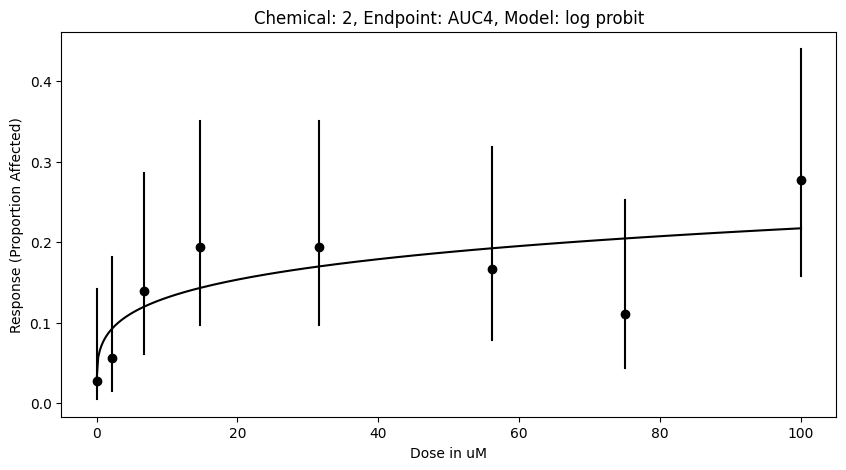

In [13]:
# Visualize the best fitting curve
LPR.response_curve(chemical_name = "2", endpoint_name = "AUC4", model = "log probit")
LPR._2_AUC4_log_probit_curve_plot

## Module 5: Output

### Benchmark Dose

Build reports with the `.report()` function. See the "example_report" folder for an example. Otherwise, output a benchmark dose table with the function `.output_benchmark_dose()` and see the results with `.output_res_benchmark_dose`


In [14]:
LPR.output_benchmark_dose()
LPR.output_res_benchmark_dose

,Chemical_ID,End_Point,Model,BMD10,BMDL,BMD50,AUC,Min_Dose,Max_Dose,AUC_Norm,DataQC_Flag,BMD_Analysis_Flag,BMD10_Flag,BMD50_Flag,bmdrc.Endpoint.ID
0,2,ANY_AUC,Quantal Linear,16.601971,10.270139,109.221272,42.271953,0.0,100.0,0.422720,2,1,1,0,2 ANY_AUC
1,2,ANY_MOV,Log Probit,0.359634,NaN,102.745670,59.544692,0.0,100.0,0.595447,2,1,1,0,2 ANY_MOV
2,2,AUC1,Quantal Linear,16.910781,11.473713,111.252876,36.031551,0.0,100.0,0.360316,2,1,1,0,2 AUC1
3,2,AUC2,Gamma,58.931335,6.038807,1637.326066,11.751667,0.0,100.0,0.162830,2,1,1,0,2 AUC2
4,2,AUC3,Log Probit,34.458461,19.175511,709.651069,16.215850,0.0,100.0,0.162158,2,1,1,0,2 AUC3
5,2,AUC4,Log Probit,7.735567,NaN,17014.594080,11.158333,0.0,100.0,0.153537,2,1,1,0,2 AUC4
6,2,MOV1,Quantal Linear,88.991563,37.337729,585.458896,16.438965,0.0,100.0,0.164390,2,1,1,0,2 MOV1
7,2,MOV4,Gamma,1.182246,0.217522,2502.230053,32.092500,0.0,100.0,0.128168,2,1,1,0,2 MOV2
8,2,MOV1,Quantal Linear,188.646274,60.947346,1241.068653,11.957500,0.0,100.0,0.136880,4,1,1,0,2 MOV3
9,2,MOV4,Gamma,0.347709,0.043182,329.417440,43.679140,0.0,100.0,0.436791,2,1,1,0,2 MOV4


### Dose

Similarly, see the dosage information with `.output_dose_table()` and see the actual table under `.output_res_dose_table`

In [15]:
LPR.output_dose_table()
LPR.output_res_dose_table

,Chemical_ID,End_Point,Dose,bmdrc.Endpoint.ID,num.affected,num.nonna,CI_Lo,CI_Hi,Response
0,2,ANY_AUC,0.00,2 ANY_AUC,11.0,36,0.180045,0.468563,0.305556
1,2,ANY_AUC,2.16,2 ANY_AUC,10.0,36,0.158483,0.439925,0.277778
2,2,ANY_AUC,6.80,2 ANY_AUC,15.0,36,0.271406,0.577997,0.416667
3,2,ANY_AUC,14.70,2 ANY_AUC,15.0,36,0.271406,0.577997,0.416667
4,2,ANY_AUC,31.60,2 ANY_AUC,13.0,36,0.224756,0.524249,0.361111
...,...,...,...,...,...,...,...,...,...
75,2,MOV4,14.70,2 MOV4,8.0,36,0.117163,0.380847,0.222222
76,2,MOV4,31.60,2 MOV4,11.0,36,0.180045,0.468563,0.305556
77,2,MOV4,56.20,2 MOV4,11.0,36,0.180045,0.468563,0.305556
78,2,MOV4,75.00,2 MOV4,9.0,36,0.137505,0.410705,0.250000


### Fits

And finally, see the fit information with `.output_fits_table()` and see the actual table under `.output_res_fits_table`

In [16]:
LPR.output_fits_table()
LPR.output_res_fits_table

,Chemical_ID,End_Point,X_vals,Y_vals,bmdrc.Endpoint.ID
0,2,ANY_AUC,0.0000,0.387885,2 ANY_AUC
1,2,ANY_AUC,0.2400,0.388817,2 ANY_AUC
2,2,ANY_AUC,0.4800,0.389747,2 ANY_AUC
3,2,ANY_AUC,0.7200,0.390676,2 ANY_AUC
4,2,ANY_AUC,0.9600,0.391603,2 ANY_AUC
...,...,...,...,...,...
59,2,MOV4,88.8889,0.429868,2 MOV4
60,2,MOV4,91.6667,0.432276,2 MOV4
61,2,MOV4,94.4444,0.434629,2 MOV4
62,2,MOV4,97.2222,0.436928,2 MOV4
